In [24]:
import keras

from keras.utils import np_utils

In [66]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Convolution3D, MaxPooling2D

In [14]:
import dicom
import fnmatch
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.misc.pilutil import imresize

In [16]:
BATCH_SIZE = 1000
CLASSES_NUM = 10
EPOCH_NUM = 100
IMAGE_SIZE = 256
TRAIN_DIR = '../rib_detection/data/train'
TEST_DIR = '../rib_detection/data/validate'

In [19]:
X_train = []
Y_train = []
X_test = []
Y_test = []

for directory, x_arr, y_arr in zip([TRAIN_DIR, TEST_DIR], [X_train, X_test], [Y_train, Y_test]):
    dcm_images = sorted([os.path.join(path, f)
                                     for path, _, files in os.walk(directory)
                                     for f in fnmatch.filter(files, 'image*.dcm')])

    dcm_labels = sorted([os.path.join(path, f)
                         for path, _, files in os.walk(directory)
                         for f in fnmatch.filter(files, 'ribsMask*.dcm')])

    for img, lbl in zip(dcm_images, dcm_labels):
        x_arr.append(imresize(dicom.read_file(img).pixel_array, [IMAGE_SIZE, IMAGE_SIZE]))
        y_arr.append(imresize(dicom.read_file(lbl).pixel_array, [IMAGE_SIZE, IMAGE_SIZE]))
        
    x_arr = np.array(x_arr, dtype=np.float32) / 255
    y_arr = np.array(y_arr, dtype=np.float32) / 255

31

In [28]:
print('X_train shape: %s' % (X_train.shape, ))
print('y_train shape: %s' % (Y_train.shape, ))
print('X_test shape: %s' % (X_test.shape, ))
print('y_test shape: %s' % (Y_test.shape, ))

X_train shape: (50000, 3, 32, 32)
y_train shape: (50000, 10)
X_test shape: (10000, 3, 32, 32)
y_test shape: (10000, 10)


In [90]:
model = Sequential()
model.add(Convolution2D(8, 5, 5, input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(16, 5, 5))
model.add(Activation('relu'))
model.add(Convolution2D(16, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, 3, 3))
model.add(Activation('relu'))
model.add(Convolution2D(16, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [91]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

hist = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCH_NUM,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 238s - loss: 3.9723 - acc: 0.1089 - val_loss: 2.2944 - val_acc: 0.1237
Epoch 2/10
50000/50000 [==============================] - 121s - loss: 2.3116 - acc: 0.1151 - val_loss: 2.2955 - val_acc: 0.1263
Epoch 3/10
50000/50000 [==============================] - 119s - loss: 2.2988 - acc: 0.1246 - val_loss: 2.2454 - val_acc: 0.1693
Epoch 4/10
50000/50000 [==============================] - 119s - loss: 2.2585 - acc: 0.1475 - val_loss: 2.1589 - val_acc: 0.1839
Epoch 5/10
50000/50000 [==============================] - 142s - loss: 2.2099 - acc: 0.1613 - val_loss: 2.1769 - val_acc: 0.1630
Epoch 6/10
50000/50000 [==============================] - 122s - loss: 2.1591 - acc: 0.1718 - val_loss: 2.1480 - val_acc: 0.1734
Epoch 7/10
50000/50000 [==============================] - 125s - loss: 2.1165 - acc: 0.1760 - val_loss: 2.0094 - val_acc: 0.2154
Epoch 8/10
50000/50000 [=======================

model

[6]


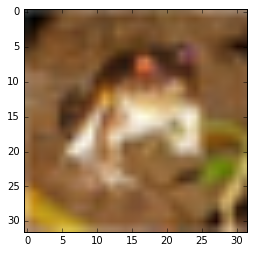

In [55]:
%matplotlib inline
plt.imshow(X_train[0].transpose([1, 2, 0]))
print(y_train[0])

(1, 8, 28, 28)


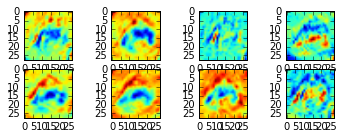

In [89]:
from keras import backend as K

# with a Sequential model
get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])
layer_output = get_layer_output([np.expand_dims(X_train[0], axis=0)])[0]
print(layer_output.shape)

for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(layer_output[0][i])